In [1]:
from IPython.lib.deepreload import original_import
%load_ext autoreload
%autoreload 2

import ex4
import numpy as np
import matplotlib.pyplot as plt

### Example of a test script

In [ ]:
import modular_ex4
import imageio
import matplotlib.pyplot as plt

# ----------------- הגדרות ניסוי -----------------
VIDEO_FILE = "House.mp4"
STEP_SIZE = 16        # פרמטר לשליטה
BORDER_CUT = 15       # פרמטר לשליטה
ENABLE_ROT = True     # עם או בלי תיקון רוטציה
CONV_POINT = None     # אופציונלי: (x,y)
# CONV_POINT = (300, 250) # לדוגמה, אם אתה רוצה למרכז אובייקט

# ----------------- ביצוע ה-Pipeline -----------------

# 1. טעינה (פעם אחת)
raw_frames = modular_ex4.load_video_frames(VIDEO_FILE, downscale_factor=2)
h, w = raw_frames[0].shape[:2]

# 2. ייצוב (פעם אחת, לוקח זמן)
# מעבירים כאן את הפרמטרים כי הייצוב מחשב optical_flow
stable_frames = modular_ex4.stabilize_video(
    raw_frames,
    step_size=STEP_SIZE,
    border_cut=BORDER_CUT,
    enable_rotation=ENABLE_ROT
)

# 3. חישוב נתיב וגיאומטריה (מהיר)
# גם כאן מעבירים את הפרמטרים כי הוא מחשב שוב optical_flow על המיוצב
transforms = modular_ex4.compute_camera_path(
    stable_frames,
    step_size=STEP_SIZE,
    border_cut=BORDER_CUT,
    convergence_point=CONV_POINT
)

canvas_geo = modular_ex4.compute_canvas_geometry(transforms, h, w)

# 4. יצירת סרטון פנורמה (Multi-Perspective)
# כאן מייצרים פנורמות שונות על ידי שינוי ה-Anchor
print("Rendering multi-perspective movie...")
movie_frames = []
anchors = np.linspace(0, 1, num=20) # 20 פריימים לסרטון

for anchor in anchors:
    # שלב הרינדור לא צריך step_size כי אין בו חישוב תנועה, רק גזירה
    pan = modular_ex4.render_strip_panorama(stable_frames, transforms, canvas_geo, strip_anchor=anchor)

    # המרה ל-uint8 לשמירה בוידאו
    pan_uint8 = (np.clip(pan, 0, 1) * 255).astype(np.uint8)
    movie_frames.append(pan_uint8)

# שמירת התוצאה
imageio.mimsave("outputs/multi_perspective_output.mp4", movie_frames, fps=10)
print("Done! Video saved.")

In [ ]:
# שמירת תמונה אחת לדוגמה (מהמרכז)
simple_panorama = modular_ex4.render_strip_panorama(stable_frames, transforms, canvas_geo, strip_padding=1, interp_order=3,prefilter=True)
modular_ex4.save_panorama(simple_panorama, filename="center_view.jpg")

### lab

In [10]:
# garden_video="Garden.mp4"
# house_video="House.mp4"
kessaria_video="Kessaria.mp4"
frames = ex4.load_video_frames(kessaria_video, downscale_factor=1)
panorama = ex4.create_mosaic(frames, step_size=16, border_cut=15)
print("done.")

Loading video from: Exercise Inputs/Kessaria.mp4
Successfully loaded 270 frames. Shape: (270, 720, 1280)
Calculating canvas limits...
Creating panorama with rotation_correction=True.
Frame 1: Correction (dy=-0.00, dth=-0.00°)
Frame 2: Correction (dy=-0.00, dth=-0.00°)
Frame 3: Correction (dy=-2.63, dth=-0.20°)
Frame 4: Correction (dy=-2.63, dth=-0.20°)
Frame 5: Correction (dy=-2.63, dth=-0.20°)
Frame 6: Correction (dy=-4.65, dth=0.13°)
Frame 7: Correction (dy=-4.65, dth=0.13°)
Frame 8: Correction (dy=-4.65, dth=0.13°)
Frame 9: Correction (dy=-7.40, dth=0.58°)
Frame 10: Correction (dy=-7.40, dth=0.58°)
Frame 11: Correction (dy=-7.40, dth=0.58°)
Frame 12: Correction (dy=-8.85, dth=1.02°)
Frame 13: Correction (dy=-8.85, dth=1.02°)
Frame 14: Correction (dy=-8.85, dth=1.02°)
Frame 15: Correction (dy=-9.60, dth=1.29°)
Frame 16: Correction (dy=-9.60, dth=1.29°)
Frame 17: Correction (dy=-9.60, dth=1.29°)
Frame 18: Correction (dy=-17.18, dth=1.96°)
Frame 19: Correction (dy=-17.18, dth=1.96°)
Fr

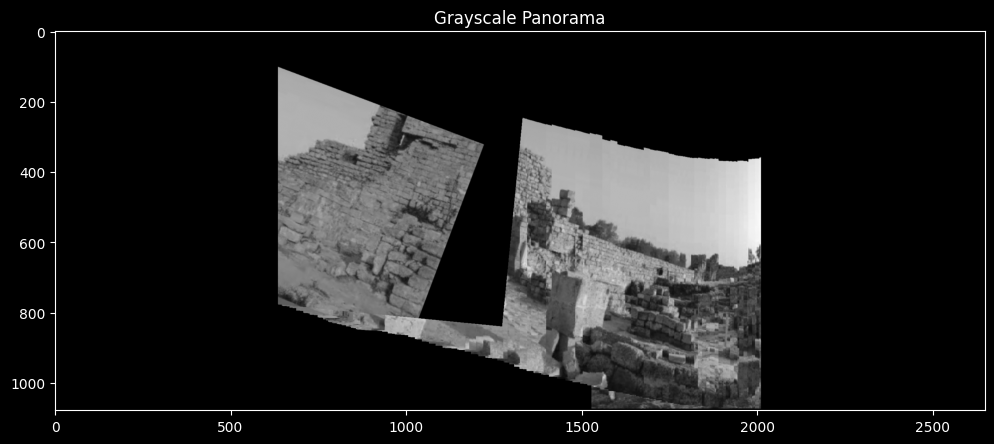

In [11]:
plt.figure(figsize=(12, 6))
plt.imshow(panorama, cmap='gray')
plt.title("Grayscale Panorama")
plt.show()

In [12]:
ex4.save_panorama(panorama, filename="Kessaria_panorama_gray_rot.png")

Saving panorama to: outputs/Kessaria_panorama_gray_rot.png...
Success! Image saved.


Analyzing camera path...


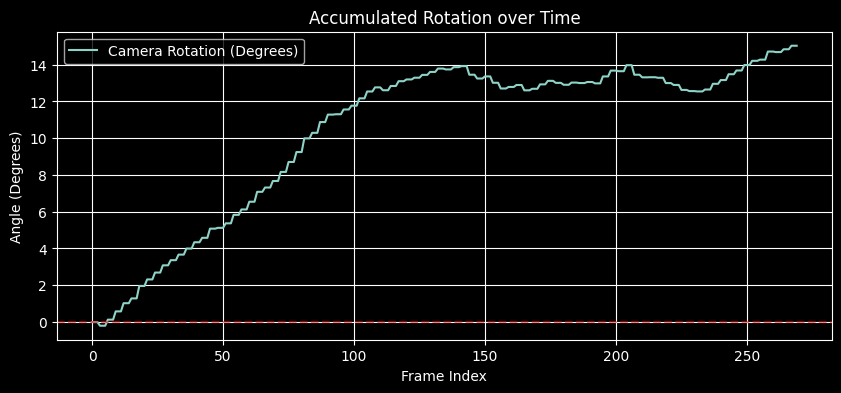

Total Rotation: 15.03 degrees


[0,
 np.float64(-0.00011432212313278968),
 np.float64(-0.0001851594477518962),
 np.float64(-0.20082573024335298),
 np.float64(-0.20082980298417705),
 np.float64(-0.20082966713877454),
 np.float64(0.12940931486360976),
 np.float64(0.12941495974124842),
 np.float64(0.12941428708495012),
 np.float64(0.578797778107903),
 np.float64(0.5787564347236986),
 np.float64(0.5787770984098614),
 np.float64(1.0243940936094857),
 np.float64(1.0243868473856024),
 np.float64(1.0243882983342083),
 np.float64(1.28520766395337),
 np.float64(1.2851872529795),
 np.float64(1.2851873007128536),
 np.float64(1.9616807763324293),
 np.float64(1.9616931309045411),
 np.float64(1.9616806998394551),
 np.float64(2.3174057645076145),
 np.float64(2.317393796062031),
 np.float64(2.3173927007488975),
 np.float64(2.690776721030817),
 np.float64(2.6907604393626343),
 np.float64(2.6907508439966428),
 np.float64(3.084227924433673),
 np.float64(3.084290932031637),
 np.float64(3.084276336067475),
 np.float64(3.36486152912539),
 

In [13]:
def plot_camera_path(frames, step_size, border_cut):
    thetas = [0]
    cumulative_theta = 0

    print("Analyzing camera path...")
    for i in range(len(frames) - 1):
        _, _, theta = ex4.optical_flow(frames[i], frames[i+1], step_size, border_cut)
        cumulative_theta += theta
        thetas.append(np.rad2deg(cumulative_theta))

    plt.figure(figsize=(10, 4))
    plt.plot(thetas, label='Camera Rotation (Degrees)')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.title("Accumulated Rotation over Time")
    plt.xlabel("Frame Index")
    plt.ylabel("Angle (Degrees)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Total Rotation: {thetas[-1]:.2f} degrees")
    return thetas

plot_camera_path(frames, step_size=16, border_cut=15)